In [49]:
# %matplotlib inline
%matplotlib notebook
%load_ext autoreload
%autoreload 2

#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import numpy     as np
import xarray    as xr
import time      as clock
import warnings
xr.set_options(keep_attrs=True)
client_runs   = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [50]:
# parameters
#___Dask Client Parameters____________________________________________________________
do_papermill      = False
do_parallel       = False
parallel_tnprc    = 128                          # total number of available CPUs
parallel_nprc     = 48                           # number of dask workers
parallel_nprc_bin = parallel_tnprc-parallel_nprc # number of processor used to parallize the binning loop
parallel_tmem     = 200                          # max. available RAM

#___Mesh Path & Save Path_____________________________________________________________
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path         = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
save_path         = None # '~/tripyview/Results/test_quiv/' #None
save_fname        = None # filename from papermill come in through save_fname
tripyrun_name     = None # papermill workflow name of notebook 
tripyrun_analysis = None # papermill diagnostic driver
tripyrun_spath_nb = None # papermill path to processed notebooks
tripyrun_spath_fig= None # papermill path to processed figures

#___Data Path & Input Names___________________________________________________________
input_paths   = list()
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')

input_names   = list()
input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
# input_names.append('TKE')

# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl    = None
do_allcycl= False
vname     = 'temp'
vname_vec = 'vec+u+v'
do_cgrain = False # do coarse graining (True) or linear interpolation (False) of u,v data to regular grid
year      = [1979, 2019]
mon       = None
day       = None
record    = None 
box       = None
depth     = 250

#___Define Reference Data, Year, Mon ...______________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None # '/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/'
ref_name  = None # 'TKE'
ref_year  = None #[1979, 2019]
ref_mon   = None
ref_day   = None
ref_record= None

#___Define Climatology________________________________________________________________
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'

#___Define Colormap Parameters________________________________________________________
# papermill doesnt like multi variable alignment in a single line
cstr      = 'blue2red'
cnum      = 15
cref      = None
crange    = None
cmin      = None
cmax      = None
cfac      = None
climit    = None
chist     = True
ctresh    = 0.995

ref_cstr  = 'wbgyr'
ref_cnum  = 15
ref_cref  = None
ref_crange= None
ref_cmin  = None
ref_cmax  = None
ref_cfac  = None
ref_climit= None
ref_chist = True
ref_ctresh= 0.995

#___Define Plot Parameters____________________________________________________________
ncol              = 2      # number of pannel columns in figure
nrow              = None
proj              = 'rob' 
box               = [-180, 180, -90, 90]
do_plt            = 'tcf'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = True   # background contour line (thin)
plt_contf         = False  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = None   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            ='fesom' # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh           = False, 
mesh_opt          = dict({'color':'k', 'linewidth':0.10})
do_enum           = False  # do enumeration of panels
do_reffig         = True   # plot reference fig when doing anomalies 
do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None
save_dpi          = 150 #300
save_fmt          = ['png']

In [51]:
# start parallel dask client
if do_parallel and not client_runs:
    from dask.distributed import Client
    
#     # disable dask worker heartbeat --> prevent error ?
#     from dask import config as cfg
#     cfg.set({'distributed.scheduler.worker-ttl': None})
    
    ##import dask
    ## dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
    print(' --> memory_limit: {:3.3f} GB'.format(parallel_tmem/(parallel_nprc)))
    client = Client(n_workers=parallel_nprc, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(parallel_tmem/parallel_nprc))
    client_runs = True
    client

In [52]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
if (n_cycl is not None): 
    cycl_s=1 if do_allcycl else n_cycl
    #__________________________________________________________________________________________________
    aux_path, aux_name = list(), list()
    input_paths_old, input_names_old = input_paths, input_names
    for ii, (ipath,iname) in enumerate(zip(input_paths,input_names)):
        for ii_cycl in range(cycl_s, n_cycl+1):
            aux_path.append(os.path.join(ipath,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(iname))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, iname))
            print(ii, aux_path[-1],aux_name[-1])
    input_paths, input_names = aux_path, aux_name
    
    #__________________________________________________________________________________________________
    if (ref_path is not None): 
        aux_path, aux_name = list(), list()
        ref_path_old, ref_name_old = ref_path, ref_name
        for ii_cycl in range(cycl_s, n_cycl+1):
            aux_path.append(os.path.join(ref_path,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(ref_name))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, ref_name))
            print('R', ref_path[-1])        
        ref_path, ref_name = aux_path, aux_name
    del(aux_path, aux_name)  

#______________________________________________________________________________________________________
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path != None): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)
    
#______________________________________________________________________________________________________    
# concatenate list = list1+list2
if (ref_path != None): 
    if isinstance(ref_path, list): 
        input_paths, input_names = ref_path + input_paths        , ref_name + input_names
    else:    
        input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names

 > warning: pickle5 module could not be found, no do_pickle 
 is possible! Therefor switch to joblib saving/loading
 > found *.jlib file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.jlib file: tripyview_fesom2_core2_srt_dep@node_focus0.jlib
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


In [53]:
#______________________________________________________________________________________________________________
# do regular binning of diapycnal velocities
Rearth     = 6371e3
dlon, dlat = 2.0, 2.0
lon_reg    = np.arange(box[0], box[1]+dlon, dlon)
lat_reg    = np.arange(box[2], box[3]+dlat, dlat)
mlon_reg, mlat_reg = (lon_reg[1:]+lon_reg[:-1])/2.0, (lat_reg[1:]+lat_reg[:-1])/2.0

#______________________________________________________________________________________________________________
# define function for longitudinal binning --> should be possible to parallelize
# this loop since each lon bin is independent
def coarsegrain_over_lon_lat(lon_i_ip1, lat_reg, dlon, dlat, data):
    
    # select all elements that are within longitudinal bin 
    if   'nod2' in list(data.dims): dim_h = 'nod2'
    elif 'elem' in list(data.dims): dim_h = 'elem'
    lonbin = data.isel({dim_h:np.where(((data.lon-lon_i_ip1[0])*(data.lon-lon_i_ip1[1]) <= 0.))[0]}).copy()
    
    # do latitudinal binning within the selected longitudinal bin
    latbin = lonbin.groupby_bins('lat',lat_reg)
    del(lonbin)
    
    # iterate through each bin in latbin and collect the data and compute area sum weighted u,v values 
    # within each lat bin 
    latbin_list = []
    dy, rad     = np.pi*Rearth*dlat/180, np.pi/180
    for bin_ii, latbin_ii in latbin:
        dx        = np.pi*Rearth*dlon/180*np.cos((bin_ii.left+bin_ii.right)/2.0*rad)
        latbin_ii = latbin_ii*latbin_ii['w_A']
        latbin_ii = latbin_ii.sum(dim=dim_h, skipna=True)/dx/dy  
         
        # if u and v are zero set to nan is most likely lsmask
        vnm = list(latbin_ii.data_vars)
        if latbin_ii[vnm[0]].data == 0.0 and latbin_ii[vnm[1]].data == 0.0:
            latbin_ii[vnm[0]].data, latbin_ii[vnm[1]].data = np.nan, np.nan   
        del(vnm)
         
        # give each bin a lat, lon dimension on value --> need for concat along dimension
        latbin_ii = latbin_ii.expand_dims({'lat': np.float32( [(bin_ii.left +bin_ii.right)/2.0] ), 
                                           'lon': np.float32( [(lon_i_ip1[0]+lon_i_ip1[1])/2.0] )
                                          })   
        # add additional dataset coords, binning boundaries and area of lon,lat bin
        latbin_ii = latbin_ii.assign_coords({'lat_bnd':(('lat', 'n2' ), np.float32( [[bin_ii.left , bin_ii.right]] ) ),
                                             'lon_bnd':(('lon', 'n2' ), np.float32( [[lon_i_ip1[0], lon_i_ip1[1]]] ) ), 
                                             'w_A'    :(('lat', 'lon'), np.float32( [[dx*dy                     ]] ) )
                                            })
        
        # make velocity data float32
        latbin_ii = latbin_ii.astype('float32')
        
        # collect each separate lat bin in a list   
        latbin_list.append(latbin_ii) 
            
    del(latbin, latbin_ii) 
    # conncat single latitudinal binning list along lat dimension into combined dataset
    latbin = xr.concat(latbin_list, dim="lat")
    return(latbin)    


#______________________________________________________________________________________________________________
# define function for linear interpolation of velocity data
def interpolate_over_lon_lat(mesh, data_v, lon_reg, lat_reg):
    import matplotlib.tri as mtri
    import matplotlib.pyplot as plt
    
    # create matplotlib triangulation with clean augmented periodic boundaries
    tri   = mtri.Triangulation(np.hstack((mesh.n_x                 , mesh.n_xa)), 
                               np.hstack((mesh.n_y                 , mesh.n_ya)), 
                               np.vstack((mesh.e_i[mesh.e_pbnd_0,:], mesh.e_ia)))
    
    # Creat triangular linear interpolator 
    vnm   = list(data_v.data_vars)
    aux_u = np.hstack(( data_v[vnm[0]].data, data_v[vnm[0]].data[mesh.n_pbnd_a] ))
    aux_v = np.hstack(( data_v[vnm[1]].data, data_v[vnm[1]].data[mesh.n_pbnd_a] ))
    interp_u, interp_v = mtri.LinearTriInterpolator(tri, aux_u ), mtri.LinearTriInterpolator(tri, aux_v )
    del(aux_u, aux_v)

    # Create a regular grid to interpolate onto
    xi, yi       = np.meshgrid(lon_reg, lat_reg)
    
    # Create regular grid u,v xarray dataset
    dict_dat, dict_coord = dict(), dict()
    dict_coord['lon'] = (['lon' ], lon_reg.astype('float32'), dict({'short_name':'Longitude', 'unit':'degree'})) 
    dict_coord['lat'] = (['lat' ], lat_reg.astype('float32'), dict({'short_name':'Latitude' , 'unit':'degree'}))
    dict_dat[vnm[0]]  = (['lat','lon'], interp_u(xi, yi).astype('float32'), data_v[vnm[0]].attrs)
    dict_dat[vnm[1]]  = (['lat','lon'], interp_v(xi, yi).astype('float32'), data_v[vnm[1]].attrs)
    data_v = xr.Dataset(data_vars=dict_dat, coords=dict_coord, attrs=data_v.attrs)
    del(xi, yi, interp_u, interp_v, dict_dat, dict_coord, tri )
    return(data_v)


#______________________________________________________________________________________________________________
data_list, data_v_list = list(), list()
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)):
    print(ii, datapath, descript)
    #__________________________________________________________________________________________________________
    yeari, moni, dayi, recordi = year, mon, day, record
    if (ii==0) and (ref_path != None): yeari, moni, dayi, recordi = ref_year, ref_mon, ref_day, ref_record
    
    
    #__________________________________________________________________________________________________________
    # load scalar data
    ts = clock.time()
    data = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=yeari, mon=moni, day=dayi, record=recordi, 
                                depth=depth, descript=descript, do_info=False, do_parallel=do_parallel)
    
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    print(' --> elasped time to load data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))
    print('')
    
    #__________________________________________________________________________________________________________
    # load vector data e.g. velocity
    ts = clock.time()
    data_v = tpv.load_data_fesom2(mesh, datapath, vname=vname_vec, year=yeari, mon=moni, day=dayi, record=recordi, 
                                  depth=depth, descript=descript, do_info=False, do_parallel=do_parallel, do_ie2n=True)
    
    # check if data where loaded
    if data_v is None: raise ValueError(f'data_vec == None, data could not be readed, your path:{datapath} might be wrong!!!')
    print(' --> elasped time to load data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data_v.nbytes/(1024**3)))
    print('')
    
    # coarse grain vector data via binning over longitude and latitude
    # do it serial
    if do_cgrain:
        ts = clock.time()
        if not do_parallel:
            lonlatbin = [None]*mlon_reg.size
            for xi in range(0, mlon_reg.size):
                lonlatbin[xi] = coarsegrain_over_lon_lat([lon_reg[xi], lon_reg[xi+1]], lat_reg, dlon, dlat, data_v)
        # do it parallel
        else:
            from joblib import Parallel, delayed
            lonlatbin = Parallel(n_jobs=parallel_nprc_bin)(delayed(coarsegrain_over_lon_lat)([lon_reg[xi], lon_reg[xi+1]], lat_reg, dlon, dlat, data) for xi in range(0,mlon_reg.size))

        # convert coarse graind lonlatbin list into lon,lat dataset with regular gridded coarse grained 
        # u,v data in it
        del(data_v)
        data_v = xr.concat(lonlatbin, dim="lon", coords="minimal", compat='override')
        del(lonlatbin)
        print(' --> elasped time to coarse data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
        
    # Linear interpolate u,v data to regular grid
    else:
        ts = clock.time()
        data_v = interpolate_over_lon_lat(mesh, data_v, lon_reg, lat_reg)
        print(' --> elasped time to interpolate data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    
    #__________________________________________________________________________________________________    
    # create reference data if given 
    if (ii==0) and (ref_path != None):
        data_ref, data_v_ref = data, data_v
        if do_reffig: 
            data_list.append(data_ref) 
            data_v_list.append(data_v_ref) 
        continue
        
    #__________________________________________________________________________________________________    
    # compute anomaly 
    if (ref_path != None):
        data_list.append(  tpv.do_anomaly(data  , data_ref  ))  
        data_v_list.append(tpv.do_anomaly(data_v, data_v_ref))  
    # compute absolute    
    else:
        data_list.append(data)
        data_v_list.append(data_v)
    del(data,data_v)
if (ref_path != None): del(data_ref, data_v_ref)

0 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/ TKE+IDEMIX, jayne
 --> elasped time to load data: 0.29 min.
 --> data uses 0.00 Gb:

 > do elem vector rotation
 > do interpolation e2n
 --> elasped time to load data: 1.12 min.
 --> data uses 0.00 Gb:

 --> elasped time to interpolate data: 0.03 min.


<IPython.core.display.Javascript object>


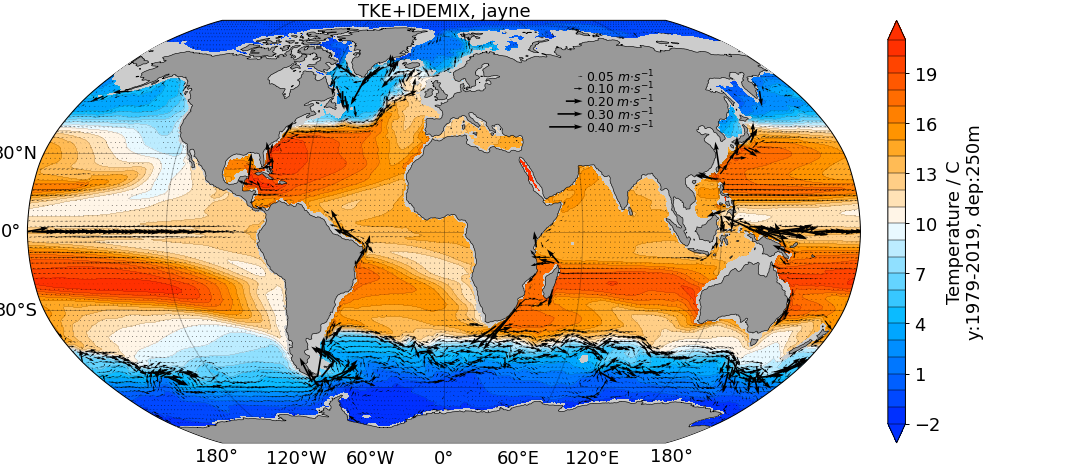

/albedo/home/pscholz/.conda/envs/py39/lib/python3.9/site-packages/matplotlib/backends/backend_nbagg.py:181: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm('matplotlib', data={'id': self.uuid})


--> cmin/cmax: norm: -1.897991/21.301758, hist: -1.445596/20.315769, fin: -1.445596/20.315769
{'cstr': 'blue2red', 'cnum': 15, 'chist': True, 'ctresh': 0.995, 'cnlab': 8, 'cmin': -1.45, 'cmax': 20.32, 'cref': 10.0, 'cmap': <matplotlib.colors.ListedColormap object at 0x7fb1e6936d60>, 'clevel': array([-2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.,
       11., 12., 13., 14., 15., 16., 17., 18., 19., 20., 21.]), 'clab': array([-2.,  1.,  4.,  7., 10., 13., 16., 19.])}


In [57]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
ndat   = len(data_list)
if   ncol != None: 
    ncol0  = np.min([ncol,ndat])    
    nrow0  = np.ceil(ndat/ncol0).astype('int')
elif nrow != None: 
    nrow0  = np.min([nrow,ndat])    
    ncol0  = np.ceil(ndat/nrow0).astype('int')
    
idx=1 if do_clim else 0       
svname = list(data_list[idx].data_vars)[0]
slabel = data_list[idx][svname].attrs['str_lsave']

#______________________________________________________________________________________________________
# do save filename path
spath  = save_path
sfpath = None
if spath!=None: 
    sfpath=list()
    for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}.{:s}'.format(svname, proj, slabel, sfmt)) )
if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality

#______________________________________________________________________________________________________
# do colorbar either single cbar or ref_cbar + anom_cbar
if (ref_path != None) and do_reffig: cb_plt, cb_plt_single, cinfo0 = [1]+[2]*(nrow0*ncol0-1), False, [ref_cinfo.copy(), cinfo.copy()]
else: cb_plt, cb_plt_single, cinfo0 = True, True, cinfo.copy() 

#__________________________________________________________________________________________________
hfig, hax, hcb = tpv.plot_hslice(mesh, data_list, cinfo=cinfo0, box=box, nrow=nrow0, ncol=ncol0, proj=proj, do_rescale=do_rescale,  
                                do_quiver=True, quiver_dat=data_v_list, quiver_opt=dict({'scale':10,}), 
                                do_quiver_leg=True,  quiver_leg_opt=dict({'x':75, 'y':60, 'dy':5, 'dw':10}), 
                                do_plt=do_plt, plt_contb=plt_contb, plt_contf=plt_contf, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum, 
                                ax_opt=dict({'fig_sizefac':3.0, 'cb_plt':cb_plt, 'cb_plt_single':cb_plt_single, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(),
                                do_save=sfpath, save_dpi=save_dpi)  

In [55]:
if do_papermill and do_parallel and client_runs:
    client.shutdown()
    client_runs = False